#Natural Language Processing with Disaster Tweets


##Problem
https://www.kaggle.com/c/nlp-getting-started

In this competition, we ae challenged to build a machine learning model that predicts wheter a given Tweet is about a real disaster or not.  The goal is to classify Tweets as either: 1: Real disaster, 0: Not related to an actual disaster.

We will use Natural Language Processing (NLP) in our model which must learn patterns from the text.

Of course! Here's a clean, professional description based on everything you provided:

## Dataset Overview

The dataset consists of 7,613 labeled Tweets, each manually classified.  
Each Tweet is described by the following columns:

| Column    | Type    | Description                                                   |
|-----------|---------|---------------------------------------------------------------|
| `id`       | int64   | A unique identifier for each tweet                            |
| `text`     | object  | The text content of the tweet                                 |
| `keyword`  | object  | A keyword extracted from the tweet (may be missing)            |
| `location` | object  | The location the tweet was sent from (may be missing)          |
| `target`   | int64   | Disaster label (1 for disaster-related, 0 for not) (train only) |

### Data Size:

- **Total rows:** 7,613
- **Total columns:** 5
- **Memory usage:** ~297.5 KB

### Missing Values:

- `keyword`: Missing in 61 rows
- `location`: Missing in 2,533 rows
- `text` and `target`: No missing values


## Data Dimensions

| Feature | Dimension |
|:---|:---|
| Text | Short texts (Tweets) — variable length |
| Target | Binary classification (0 or 1) |

- The `text` field is the primary feature used for building the classification model.
- `keyword` and `location` may provide useful auxiliary information, although they are partially missing.

Training data is stored within train.csv, while the test set is at test.csv.

## Evaluation Metric

The competition is evaluated using the **F1 Score**, a balance between **Precision** and **Recall**:

$$F1 = 2 \times \frac{precision \times recall}{precision + recall}$$


Where:

- **Precision** = $$( \frac{TP}{TP + FP} )$$ How many predicted disasters were actually disasters
- **Recall** = $$( \frac{TP}{TP + FN} )$$  How many actual disasters were successfully predicted

**Maximizing the F1 score** ensures the model balances correctly between false positives and false negatives.



In [1]:
# install gensim for NLP analysis
!pip install gensim

In [2]:
# Load all necessary libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')
import re
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, Bidirectional, Concatenate

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_path = '/content/drive/MyDrive/CU/NLP-GRU/'

In [5]:
dfs = []
def load_csv_file(file_name):
    df = pd.read_csv(base_path+file_name)
    return df


train_df = load_csv_file('train.csv')
test_df = load_csv_file('test.csv')

#Exploratory Data Analysis (EDA)
Our approach to exploratory data analysis focused on preparing the textual data for deep learning modeling while investigating potential feature engineering opportunities. The main steps were:

1. **Text Vectorization**:  
   Since Tweets are composed of raw text, they must be transformed into a numerical representation to be used by a deep learning model.  
   To accomplish this, we utilized Word2Vec embeddings, which map each word into a continuous dense vector space based on semantic meaning.

2. **Text Preprocessing and Tokenization**:
   - Before vectorization, we first **tokenized** the tweets — that is, we split each text string into an ordered list of individual words (tokens).
   - Given the high frequency of common English words (e.g., *and*, *of*, *the*, etc.), we removed **stopwords** from the tokenized text. This step helps to reduce noise and focus the model on more meaningful words.
   - After stopword removal, we examined whether certain words showed a **correlation** with the target label (`disaster` vs. `non-disaster`).  
   - If moderate or strong correlations were observed, we engineered **additional features**:
     - Indicators for the presence of highly predictive **disaster-related words**.
     - Indicators for the presence of highly predictive **non-disaster words**.

3. **Dataset Preparation**:
   - Finally, we built a clean dataset containing the tokenized text and the engineered features.
   - This structured dataset served as the input for training our GRU-based deep learning models.


In [6]:
# Look at the first few rows
print(train_df.tail())
print(train_df.info())
print(train_df.isnull().sum())


         id keyword location  \
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usag

target
0    4342
1    3271
Name: count, dtype: int64


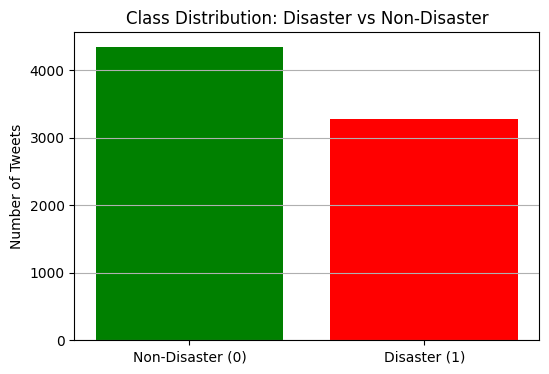

In [7]:
class_counts = train_df['target'].value_counts()
print(class_counts)

plt.figure(figsize=(6,4))
plt.bar(class_counts.index, class_counts.values, color=['green', 'red'])
plt.xticks([0, 1], ['Non-Disaster (0)', 'Disaster (1)'])
plt.ylabel('Number of Tweets')
plt.title('Class Distribution: Disaster vs Non-Disaster')
plt.grid(axis='y')
plt.show()

# Load data set library

In [8]:
# English stopword set
stop_words = set(stopwords.words('english'))

In [9]:
# Clean the text, remove urls, remove special characters, remove extra spaces
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

train_df['tokens'] = train_df['clean_text'].apply(lambda x: x.split())
test_df['tokens'] = test_df['clean_text'].apply(lambda x: x.split())

# Tokenization + Stopword Removal
train_df['tokens'] = train_df['clean_text'].apply(lambda x: [word for word in x.split() if word not in stop_words])
test_df['tokens'] = test_df['clean_text'].apply(lambda x: [word for word in x.split() if word not in stop_words])

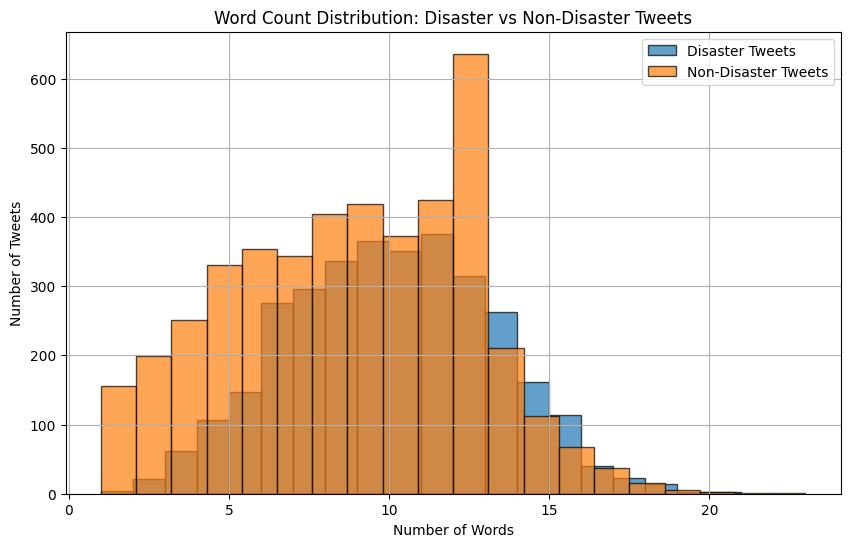

In [10]:
train_df['word_count'] = train_df['tokens'].apply(len)

# Split by target
disaster = train_df[train_df['target'] == 1]['word_count']
nondisaster = train_df[train_df['target'] == 0]['word_count']

# Plot
plt.figure(figsize=(10,6))
plt.hist(disaster, bins=20, alpha=0.7, label='Disaster Tweets', edgecolor='black')
plt.hist(nondisaster, bins=20, alpha=0.7, label='Non-Disaster Tweets', edgecolor='black')
plt.title('Word Count Distribution: Disaster vs Non-Disaster Tweets')
plt.xlabel('Number of Words')
plt.ylabel('Number of Tweets')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
print("Disaster tweets word count stats:")
print(disaster.describe())

print("\nNon-Disaster tweets word count stats:")
print(nondisaster.describe())


Disaster tweets word count stats:
count    3271.000000
mean        9.545399
std         3.206406
min         1.000000
25%         7.000000
50%        10.000000
75%        12.000000
max        21.000000
Name: word_count, dtype: float64

Non-Disaster tweets word count stats:
count    4342.000000
mean        8.793413
std         3.681068
min         1.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        23.000000
Name: word_count, dtype: float64


In [12]:
# Disaster and Non-Disaster words
disaster_words = [word for tokens in train_df[train_df['target'] == 1]['tokens'] for word in tokens if word not in stop_words]
nondisaster_words = [word for tokens in train_df[train_df['target'] == 0]['tokens'] for word in tokens if word not in stop_words]

# Word counts
disaster_counts = Counter(disaster_words)
nondisaster_counts = Counter(nondisaster_words)

# Build emergency keywords
emergency_keywords = []
nonemergency_keywords = []

# Thresholds you can tweak
min_disaster_count = 10   # Only keep words that appear at least 10 times
min_ratio = 3.0           # Disaster count must be 3x more than non-disaster

for word, count in disaster_counts.items():
    if count >= min_disaster_count:
        non_count = nondisaster_counts.get(word, 0)
        if non_count == 0 or (count / (non_count + 1e-5)) >= min_ratio:
            emergency_keywords.append(word)
for word, count in nondisaster_counts.items():
    if count >= min_disaster_count:
        non_count = disaster_counts.get(word, 0)
        if non_count == 0 or (count / (non_count + 1e-5)) >= min_ratio:
            nonemergency_keywords.append(word)

print(f"Number of emergency keywords: {len(emergency_keywords)}")
print("Sample emergency keywords:", emergency_keywords[:20])

print(f"Number of non-emergency keywords: {len(nonemergency_keywords)}")
print("Sample non-emergency keywords:", nonemergency_keywords[:20])


Number of emergency keywords: 274
Sample emergency keywords: ['earthquake', 'forest', 'near', 'la', 'evacuation', 'wildfires', 'california', 'hwy', 'closed', 'due', 'county', 'disaster', 'heavy', 'flash', 'street', 'area', 'three', 'south', 'myanmar', 'flag']
Number of non-emergency keywords: 307
Sample non-emergency keywords: ['whats', 'love', 'cant', 'always', 'try', 'night', 'much', 'new', 'lord', 'check', 'youre', 'awesome', 'head', 'know', 'better', 'r', 'happy', 'see', 'upon', 'im']


In [13]:
# Function to count emergency keywords
def count_emergency_keywords(tokens):
    return sum(1 for word in tokens if word in emergency_keywords)

def count_nonemergency_keywords(tokens):
    return sum(1 for word in tokens if word in nonemergency_keywords)

# Add feature to train and test sets
train_df['emergency_word_count'] = train_df['tokens'].apply(count_emergency_keywords)
test_df['emergency_word_count'] = test_df['tokens'].apply(count_emergency_keywords)
train_df['nonemergency_word_count'] = train_df['tokens'].apply(count_nonemergency_keywords)
test_df['nonemergency_word_count'] = test_df['tokens'].apply(count_nonemergency_keywords)


In [14]:
train_df['has_emergency_keyword'] = (train_df['emergency_word_count'] > 0).astype(int)
test_df['has_emergency_keyword'] = (test_df['emergency_word_count'] > 0).astype(int)
train_df['has_nonemergency_keyword'] = (train_df['nonemergency_word_count'] > 0).astype(int)
test_df['has_nonemergency_keyword'] = (test_df['nonemergency_word_count'] > 0).astype(int)

In [15]:
disaster_words = [word for tokens in train_df[train_df['target'] == 1]['tokens'] for word in tokens if word not in stop_words]
nondisaster_words = [word for tokens in train_df[train_df['target'] == 0]['tokens'] for word in tokens if word not in stop_words]

disaster_counts = Counter(disaster_words)
nondisaster_counts = Counter(nondisaster_words)

print("Top 20 words in Disaster tweets (no stopwords):")
print(disaster_counts.most_common(20))

print("\nTop 20 words in Non-Disaster tweets (no stopwords):")
print(nondisaster_counts.most_common(20))


Top 20 words in Disaster tweets (no stopwords):
[('fire', 180), ('news', 140), ('via', 121), ('disaster', 117), ('california', 111), ('suicide', 110), ('police', 107), ('amp', 107), ('people', 105), ('killed', 93), ('like', 92), ('pm', 89), ('hiroshima', 89), ('storm', 85), ('us', 84), ('crash', 84), ('fires', 84), ('families', 81), ('train', 79), ('emergency', 76)]

Top 20 words in Non-Disaster tweets (no stopwords):
[('like', 253), ('im', 248), ('amp', 193), ('new', 170), ('get', 163), ('dont', 154), ('one', 128), ('body', 113), ('via', 99), ('would', 97), ('video', 96), ('people', 91), ('love', 90), ('cant', 86), ('us', 86), ('time', 85), ('know', 85), ('back', 84), ('got', 83), ('see', 82)]


has_emergency_keyword
0    4684
1    2929
Name: count, dtype: int64


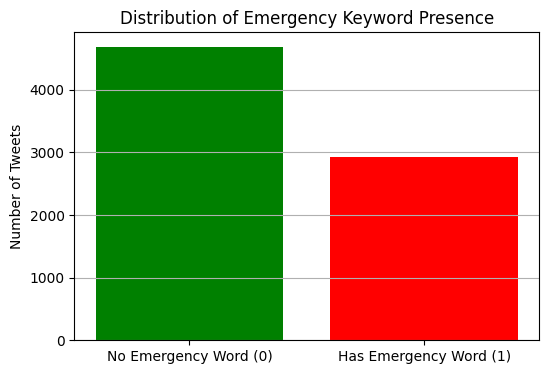

In [16]:
import matplotlib.pyplot as plt

has_emergency_counts = train_df['has_emergency_keyword'].value_counts()
print(has_emergency_counts)

# Plot
plt.figure(figsize=(6,4))
plt.bar(has_emergency_counts.index, has_emergency_counts.values, color=['green', 'red'])
plt.xticks([0, 1], ['No Emergency Word (0)', 'Has Emergency Word (1)'])
plt.ylabel('Number of Tweets')
plt.title('Distribution of Emergency Keyword Presence')
plt.grid(axis='y')
plt.show()


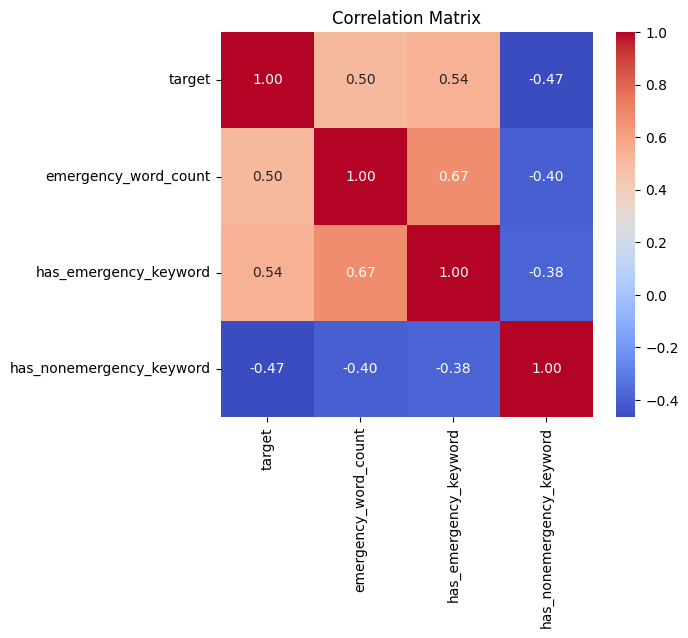

In [17]:
import seaborn as sns
import pandas as pd

correlation_df = train_df[['target', 'emergency_word_count', 'has_emergency_keyword','has_nonemergency_keyword']]

# Compute correlation matrix
corr_matrix = correlation_df.corr()

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [18]:
train_df.head()

,id,keyword,location,text,target,clean_text,tokens,word_count,emergency_word_count,nonemergency_word_count,has_emergency_keyword,has_nonemergency_keyword
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[deeds, reason, earthquake, may, allah, forgiv...",7,1,0,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",7,3,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[residents, asked, shelter, place, notified, o...",11,1,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...,"[people, receive, wildfires, evacuation, order...",6,3,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[got, sent, photo, ruby, alaska, smoke, wildfi...",9,1,0,1,0


#EDA Results

Our exploratory data analysis focused on understanding the structure of the tweets, their relationship to the target labels, and engineering features that could enhance model performance:

### 1. **Word Count Analysis**

We analyzed the distribution of the number of words in disaster vs. non-disaster tweets.

- **Most tweets** contained between **5 and 15 words** after tokenization and stopword removal.
- **Non-disaster tweets** tend to be slightly shorter on average compared to disaster-related tweets.
- Based on this, we chose a **maximum sequence length of 20 words** to cover the majority of tweets without significant truncation.


### 2. **Class Distribution**

The dataset shows a slight imbalance between the classes:

- **Non-Disaster Tweets (0):** ~4,300 samples
- **Disaster Tweets (1):** ~3,300 samples

While the imbalance is not severe, it was taken into account when designing evaluation metrics and training strategies.


### 3. **Keyword Feature Engineering**

We explored the relationship between specific keywords and the disaster label. After removing stopwords, we identified words that were highly correlated with either disaster or non-disaster tweets.

- **Number of Emergency Keywords Identified:** 274
  - Sample Emergency Keywords:  
    `['earthquake', 'forest', 'evacuation', 'wildfires', 'california', 'disaster', 'flash', 'area', 'emergency']`
  
- **Number of Non-Emergency Keywords Identified:** 307
  - Sample Non-Emergency Keywords:  
    `['whats', 'love', 'cant', 'always', 'try', 'night', 'awesome', 'see', 'happy', 'new']`

We created two binary features:
- `has_emergency_keyword`
- `has_nonemergency_keyword`
  
to indicate whether each tweet contained any of these identified keywords.

### 4. **Top Words in Disaster vs. Non-Disaster Tweets**

The top 20 most frequent words differed notably between disaster and non-disaster tweets:

| Disaster Tweets | Non-Disaster Tweets |
|:---|:---|
| `fire`, `news`, `disaster`, `california`, `suicide`, `police`, `storm`, `crash` | `like`, `im`, `new`, `get`, `dont`, `love`, `video`, `know` |

- **Disaster tweets** focused on events, emergencies, and disasters.
- **Non-disaster tweets** tended to be conversational or emotional in nature.

### 5. **Correlation Analysis**

We computed a correlation matrix between the features and the target label:

- `has_emergency_keyword` showed a **positive correlation** with the disaster label (`r ≈ 0.54`).
- `has_nonemergency_keyword` showed a **negative correlation** with the disaster label (`r ≈ -0.47`).
- Raw `emergency_word_count` also moderately correlated with the disaster target.

#Word Embedding Strategy: Word2Vec

Before feeding text into a deep learning model, we must convert words into a numerical format that the model can understand. However, simply assigning random numbers or one-hot encoding words does not capture the rich relationships between words in natural language.

To address this, we use Word2Vec, a technique that learns dense vector representations of words based on their surrounding context. Words that appear in similar contexts (e.g., "fire" and "smoke") will be placed closer together in the embedding space.

- Word2Vec captures semantic meaning and relationships between words.
- Word2Vec It transforms each word into a n-dimensional dense vector, allowing our model to better understand word similarity and context.
- Word2Vec It helps the model generalize better to unseen or rare words during disaster prediction.

Given the relatively small size of our dataset (~7,600 tweets), selecting an appropriate embedding dimension is crucial to balance model performance and computational efficiency. Research suggests that for smaller corpora, lower-dimensional embeddings can be effective. For instance, Kwan (2019) recommends starting with embedding dimensions around 50 for small datasets to capture essential semantic relationships without overfitting. Following Kwan (2019), we chose embedding dimensions between 50 and 200 given our smaller dataset size.

In [19]:
def get_word_vectors(e_dim):
  w2v_model = Word2Vec(
      sentences=train_df['tokens'],
      vector_size=e_dim,
      window=5,
      min_count=1,
      workers=4
  )

  print(f"Vocabulary size: {len(w2v_model.wv)}")
  return w2v_model.wv

To prepare the text data for input into our deep learning model, we need to perform two complementary steps:

### 1. **Learning Word Embeddings (Word2Vec)**

First, we use **Word2Vec** to learn dense vector representations of words based on their context in the dataset.  
Word2Vec maps each word to a vector in a continuous space where words with similar meanings are positioned closer together.

- We train Word2Vec directly on the tokenized tweets (`tokens` column) to capture the semantic relationships present in our specific dataset.
- Each word is mapped to a **n-dimensional** vector, a size chosen to balance representational power with the risk of overfitting, especially considering the relatively small dataset size (~7,600 tweets).

These word vectors will later initialize the model's embedding layer, giving the model a rich understanding of word meanings right from the start.


### 2. **Mapping Text to Word IDs (Tokenizer)**

Deep learning models cannot work directly with words — they require numerical input.  
- Create a **mapping** from each word to a unique integer ID.
- Convert each tweet from a sequence of words to a **sequence of integer IDs**.
- **Pad** these sequences to a uniform length so that all inputs have the same dimensions.

This allows each tweet to be represented as a fixed-length numerical vector, suitable for input into our model.

In [40]:
def get_embeddings_index(embedding_dim):
  fname=''
  if embedding_dim == 25:
    fname='glove.twitter.27B.25d.txt'
  elif embedding_dim == 50:
    fname='glove.twitter.27B.50d.txt'
  elif embedding_dim == 100:
    fname='glove.twitter.27B.100d.txt'
  elif embedding_dim == 150:
    fname='glove.twitter.27B.150d.txt'
  else:
    fname='glove.twitter.27B.200d.txt'

  # Load embeddings into a dictionary
  embeddings_index = {}
  with open(f'{base_path}{fname}', encoding='utf8') as f:
      for line in f:
          values = line.split()
          word = values[0]
          coefs = np.asarray(values[1:], dtype='float32')
          embeddings_index[word] = coefs

  print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")
  return embeddings_index


In [60]:
def build_tokenizer(embeddings_index, train_df):
  word_vectors = get_word_vectors(embedding_dim)
  # Tokenizer to map words to IDs
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(train_df['clean_text'])

  # Texts to sequences (IDs)
  sequences = tokenizer.texts_to_sequences(train_df['clean_text'])
  word_index = tokenizer.word_index
  print(f"Number of unique words (after tokenizer): {len(word_index)}")

  # Pad sequences to same length
  max_length = 32
  X = pad_sequences(sequences, maxlen=max_length, padding='post')
  y = train_df['target'].values

  embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
      else:
          # If word not found, random initialize
          embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))
  return X, y, embedding_matrix, max_length, word_index,tokenizer

In [42]:
def get_train_test_split(X, y):
  # 80% train, 20% validation split
  X_train, X_val, y_train, y_val = train_test_split(
      X, y, test_size=0.2, random_state=42
  )

  return X_train, X_val, y_train, y_val


#Architecture

Text (tweets in this context) often contain crucial sequential information. GRUs are a type of Recurrent Neural Network (RNN) designed to handle sequential data effectively. They capture dependencies in text sequences, making them ideal at understanding the context within a tweet.

Long Short-Term Memory (LSTM) networks are also used for sequence modeling, GRUs offer a more streamlined architecture with fewer parameters. This efficiency translates to faster training times and reduced computational resources, which is beneficial when working with datasets like disaster tweets.

## Full Architecture

The model combines pretrained semantic understanding (via embeddings), sequential pattern learning (via Bidirectional GRU), structured feature integration (via auxiliary inputs), and regularization (via dropout) to make robust disaster predictions from noisy Twitter data.


**Layer:** Convert words into dense vecotrs with semantic meaning
**Bidirectional GRU:** Capture sequential patterns in both directions
**Dropout:** Regularize and prevent overfitting
**Emergency/Non-Emergency Inputs:** Provide extra structured information
**Concatentation:** Merge semantic and auxillary features
**Dense (Sigmoid):** Predict probability of disaster

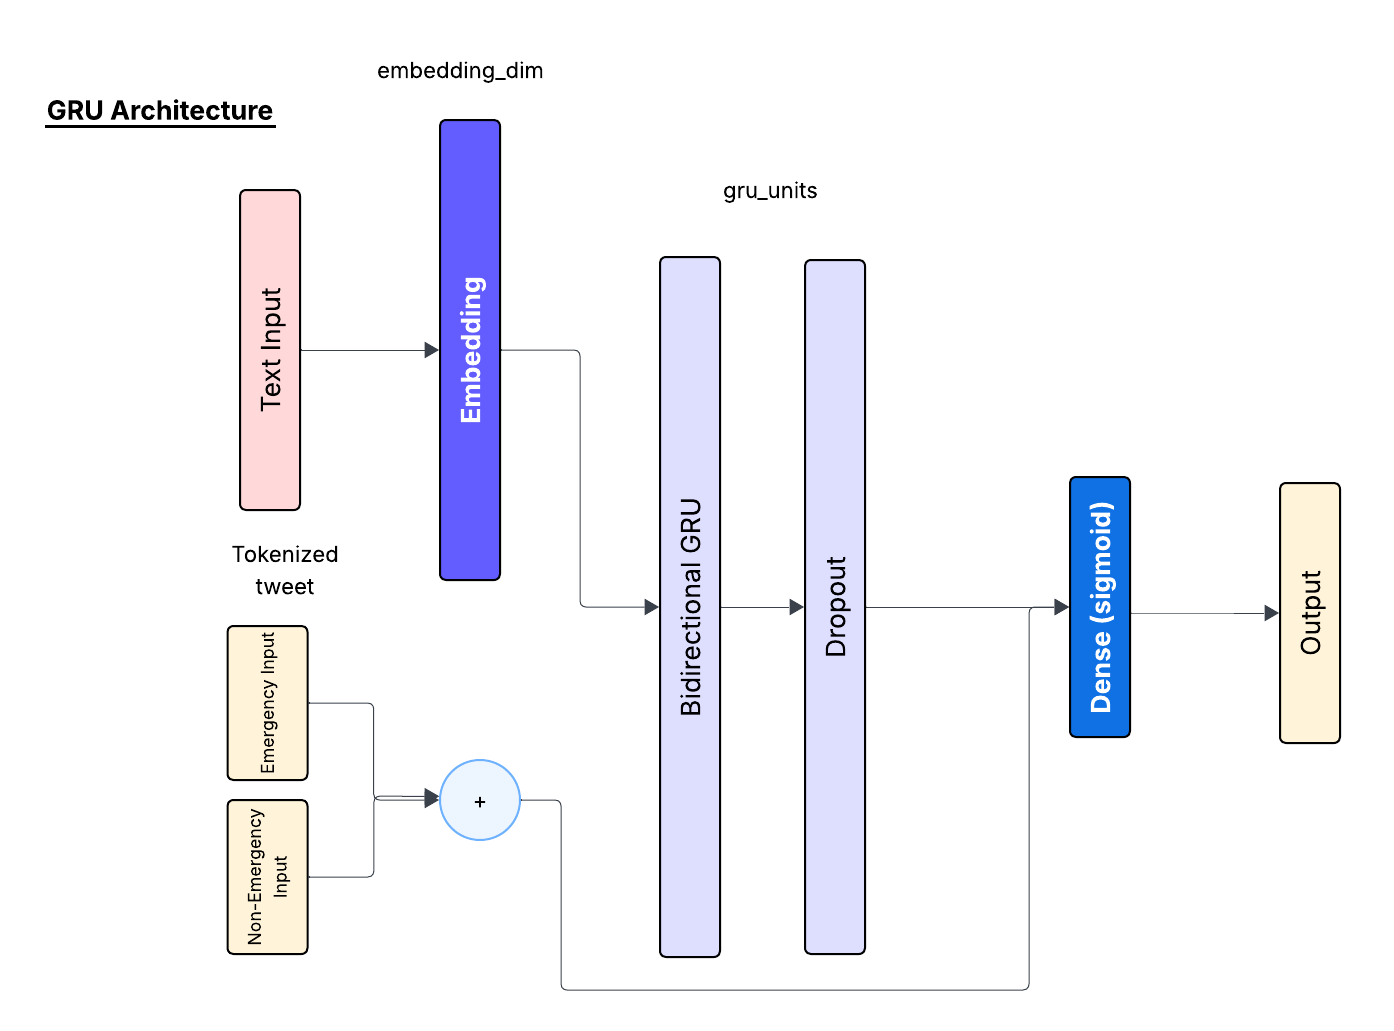

Research has demonstrated the efficacy of combining GRU architectures with Word2Vec embeddings for text classification tasks. For instance, a study highlighted that a two-layer GRU model with pre-trained Word2Vec embeddings achieved superior accuracy in text classification tasks compared to other models.

To achieve the best performance on our disaster tweet classification task, we will conduct a series of experiments aimed at optimizing the model architecture.
Specifically, we will systematically explore different combinations of key hyperparameters related to the model's embedding and recurrent layers.

Our goal is to identify the model configuration that maximizes F1 Score on the validation set.

F1 Score is the chosen metric because it balances precision and recall, which is critical for disaster detection tasks where both false positives and false negatives can have significant implications.

|Hyperparameter|Values to Try|
|-|-|
|Word Embedding Dimension (embedding_dims_list)|[25,50,100,200]|
|GRU Units|[32,64,128,256]|


Embedding Dimension: Controls the size of the vector representation for each word. Smaller dimensions (e.g., 50) are more efficient and sufficient for small datasets, while larger dimensions (e.g., 150) can potentially capture more nuanced semantic relationships.

GRU Units: Defines the number of hidden units in the GRU layer, influencing the model’s capacity to learn sequential patterns. Fewer units (e.g., 32) lead to faster training and less risk of overfitting, while more units (e.g., 256) can potentially capture more complex dependencies.

Initially, we begain by training a Word2Vec model directly on the available disaster tweet dataset.

However, after careful evaluation, we decided to utilize pretrained word embeddings — specifically GloVe Twitter embeddings — instead of building embeddings from scratch on our dataset.  Main reason driving this was the size of the training dataset. We used GloVe embeddings pretrained on Twitter data (Pennington et al., 2014).

Our experiment therefore was changed to use GloVe twitter embeddings.

In [49]:
def create_gru_model(
    vocab_size,
    embedding_dim,
    embedding_matrix,
    max_length,
    gru_units=64,
    dropout_rate=0.2,
    bidirectional=True,
    use_emergency_feature=True,
    use_nonemergency_feature=True,
    trainable_embedding=False
):
    """
    Creates a GRU model with optional emergency and non-emergency keyword inputs.

    Parameters:
    - vocab_size: size of the vocabulary (len(word_index) + 1)
    - embedding_dim: size of each word vector
    - embedding_matrix: pre-trained Word2Vec matrix
    - max_length: max tweet length (number of words)
    - gru_units: number of GRU units
    - dropout_rate: dropout after GRU
    - bidirectional: wrap GRU with Bidirectional layer
    - use_emergency_feature: whether to include emergency feature
    - use_nonemergency_feature: whether to include non-emergency feature
    - trainable_embedding: whether to fine-tune Word2Vec embeddings

    Returns:
    - compiled Keras model
    """

    text_input = Input(shape=(max_length,), name='text_input')

    x = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=trainable_embedding
    )(text_input)

    if bidirectional:
        x = Bidirectional(GRU(gru_units))(x)
    else:
        x = GRU(gru_units)(x)

    x = Dropout(dropout_rate)(x)
    inputs = [text_input]

    concat_list = [x]

    if use_emergency_feature:
        emergency_input = Input(shape=(1,), name='emergency_input')
        concat_list.append(emergency_input)
        inputs.append(emergency_input)

    if use_nonemergency_feature:
        nonemergency_input = Input(shape=(1,), name='nonemergency_input')
        concat_list.append(nonemergency_input)
        inputs.append(nonemergency_input)

    if len(concat_list) > 1:
        x = Concatenate()(concat_list)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


class F1EarlyStopping(Callback):
    def __init__(self, validation_data, patience=5, min_epochs=10, verbose=1):
        super(F1EarlyStopping, self).__init__()
        self.X_val, self.y_val = validation_data
        self.patience = patience
        self.min_epochs = min_epochs
        self.best_f1 = 0
        self.wait = 0
        self.best_weights = None
        self.stopped_epoch = 0
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs=None):
        # Predict correctly based on input type (dict or array)
        if isinstance(self.X_val, dict):
            y_pred = (self.model.predict(self.X_val, verbose=0) > 0.5).astype(int)
        else:
            y_pred = (self.model.predict(self.X_val, verbose=0) > 0.5).astype(int)

        f1 = f1_score(self.y_val, y_pred)

        if self.verbose > 0:
            print(f"\nEpoch {epoch+1}: val_f1_score = {f1:.4f}")

        if epoch + 1 >= self.min_epochs:  # Wait until minimum epochs are completed
            if f1 > self.best_f1:
                self.best_f1 = f1
                self.wait = 0
                self.best_weights = self.model.get_weights()  # Save the best weights
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                    if self.verbose > 0:
                        print(f"Early stopping triggered. Restoring best model with F1: {self.best_f1:.4f}")

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.best_weights is not None:
            if self.verbose > 0:
                print(f"Restoring model weights from epoch {self.stopped_epoch - self.wait + 1}")
            self.model.set_weights(self.best_weights)

# Define the callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',    # Watch the validation loss
    factor=0.5,            # Reduce by a factor of 0.5
    patience=3,            # If val_loss doesn't improve for 3 epochs, reduce
    verbose=1,             # Print when reducing
    min_lr=1e-6            # Smallest allowed learning rate
)


In [61]:
import numpy as np
from sklearn.metrics import f1_score

# Hyperparameter grid
embedding_dims_list = [25,50,100,200]
gru_units_list = [32, 64, 128, 256]

# Track best results
results = []
tokenizers = {}

# Outer loop over embeddings and GRU units
for embedding_dim in embedding_dims_list:
    print(f"\n--- Training with embedding_dim={embedding_dim} ---")
    embeddings_index = get_embeddings_index(embedding_dim)
    X, y, embedding_matrix, max_length, word_index, tokenizer=build_tokenizer(embeddings_index,train_df)

    X_train, X_val, y_train, y_val = get_train_test_split(X,y)

    for gru_units in gru_units_list:
        print(f"\n--- Training with gru_units={gru_units} ---")
        train_inputs = {
            'text_input': X_train,
            'emergency_input': X_train.reshape(-1, 1)
        }

        val_inputs = {
            'text_input': X_val,
            'emergency_input': X_val.reshape(-1, 1)
        }
        # Create model
        model = create_gru_model(
            vocab_size=len(word_index) + 1,
            embedding_dim=embedding_dim,
            embedding_matrix=embedding_matrix,
            max_length=32,
            gru_units=gru_units,
            dropout_rate=0.2,
            bidirectional=True,
            use_emergency_feature=False,
            use_nonemergency_feature=False,
            trainable_embedding=False
        )


        f1_early_stopping = F1EarlyStopping(
            validation_data=(X_val, y_val),
            patience=5,
            verbose=1
        )

        # Train
        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=64,
            callbacks=[lr_scheduler,f1_early_stopping],
            verbose=1
        )

        # Evaluate
        y_val_pred = (model.predict(X_val, verbose=0) > 0.5).astype('int32')
        f1 = f1_score(y_val, y_val_pred)

        print(f"F1 Score: {f1:.4f}")
        # Save the model
        model_filename = f"{base_path}model_emb{embedding_dim}_gru{gru_units}.h5"
        model.save(model_filename)

        # Save results
        results.append({
            'embedding_dim': embedding_dim,
            'gru_units': gru_units,
            'f1_score': f1,
            'model_filename': model_filename
        })
        tokenizers[model_filename] = tokenizer

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score', ascending=False)
print("\nTop Configurations by F1 Score:")
print(results_df.head())


--- Training with embedding_dim=25 ---
Loaded 1193514 word vectors from GloVe.
Vocabulary size: 16765
Number of unique words (after tokenizer): 16899

--- Training with gru_units=32 ---
Epoch 1/50
91/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6693 - loss: 0.6252
Epoch 1: val_f1_score = 0.7355
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6720 - loss: 0.6222 - val_accuracy: 0.7846 - val_loss: 0.4786 - learning_rate: 0.0010
Epoch 2/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7928 - loss: 0.4708
Epoch 2: val_f1_score = 0.7475
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7921 - loss: 0.4713 - val_accuracy: 0.8030 - val_loss: 0.4568 - learning_rate: 0.0010
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7870 - loss: 0.4662
Epoch 3: val_f1_score = 0.7508
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7870 - loss: 0.4662 - val_accuracy: 0.8030 - val_loss: 0.4540 - learning_rate: 0.0010
Epoch 4/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

F1 Score: 0.7608

--- Training with gru_units=64 ---
Epoch 1/50
90/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6656 - loss: 0.6071
Epoch 1: val_f1_score = 0.7478
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6691 - loss: 0.6038 - val_accuracy: 0.7971 - val_loss: 0.4644 - learning_rate: 0.0010
Epoch 2/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7868 - loss: 0.4776
Epoch 2: val_f1_score = 0.7386
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7870 - loss: 0.4769 - val_accuracy: 0.7997 - val_loss: 0.4485 - learning_rate: 0.0010
Epoch 3/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7940 - loss: 0.4629
Epoch 3: val_f1_score = 0.7650
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7937 - loss: 0.4632 - val_accuracy: 0.8043 - val_loss: 0.4482 - learning_rate: 0.0010
Epoch 4/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8017 - loss: 0.4536
Epoch 4: val_f1_score = 0.7598
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8015 - loss: 

F1 Score: 0.7618

--- Training with gru_units=128 ---
Epoch 1/50
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6777 - loss: 0.5872
Epoch 1: val_f1_score = 0.6780
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6796 - loss: 0.5854 - val_accuracy: 0.7761 - val_loss: 0.4825 - learning_rate: 0.0010
Epoch 2/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7762 - loss: 0.4841
Epoch 2: val_f1_score = 0.7383
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7770 - loss: 0.4831 - val_accuracy: 0.7984 - val_loss: 0.4489 - learning_rate: 0.0010
Epoch 3/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7890 - loss: 0.4572
Epoch 3: val_f1_score = 0.7058
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7891 - loss: 0.4573 - val_accuracy: 0.7892 - val_loss: 0.4678 - learning_rate: 0.0010
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7952 - loss: 0.4523
Epoch 4: val_f1_score = 0.7614
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7953 - loss:

F1 Score: 0.7538

--- Training with gru_units=256 ---
Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7009 - loss: 0.5609
Epoch 1: val_f1_score = 0.7570
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7014 - loss: 0.5604 - val_accuracy: 0.8011 - val_loss: 0.4554 - learning_rate: 0.0010
Epoch 2/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7831 - loss: 0.4708
Epoch 2: val_f1_score = 0.7545
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7834 - loss: 0.4704 - val_accuracy: 0.7919 - val_loss: 0.4631 - learning_rate: 0.0010
Epoch 3/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7809 - loss: 0.4633
Epoch 3: val_f1_score = 0.7634
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7814 - loss: 0.4629 - val_accuracy: 0.7978 - val_loss: 0.4639 - learning_rate: 0.0010
Epoch 4/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7919 - loss: 0.4557
Epoch 4: val_f1_score = 0.7438
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7921 - loss:

F1 Score: 0.7642

--- Training with embedding_dim=50 ---
Loaded 1193514 word vectors from GloVe.
Vocabulary size: 16765
Number of unique words (after tokenizer): 16899

--- Training with gru_units=32 ---
Epoch 1/50
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6315 - loss: 0.6460
Epoch 1: val_f1_score = 0.6998
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6325 - loss: 0.6451 - val_accuracy: 0.7702 - val_loss: 0.5043 - learning_rate: 0.0010
Epoch 2/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7778 - loss: 0.4778
Epoch 2: val_f1_score = 0.7479
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7785 - loss: 0.4769 - val_accuracy: 0.8070 - val_loss: 0.4456 - learning_rate: 0.0010
Epoch 3/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8026 - loss: 0.4440
Epoch 3: val_f1_score = 0.7502
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8027 - loss: 0.4441 - val_accuracy: 0.8089 - val_loss: 0.4418 - learning_rate: 0.0010
Epoch 4/50
89/96 ━━━━━━━━━━━━━━

F1 Score: 0.7733

--- Training with gru_units=64 ---
Epoch 1/50
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6539 - loss: 0.6069
Epoch 1: val_f1_score = 0.7513
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6561 - loss: 0.6051 - val_accuracy: 0.8056 - val_loss: 0.4506 - learning_rate: 0.0010
Epoch 2/50
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7988 - loss: 0.4530
Epoch 2: val_f1_score = 0.7595
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7989 - loss: 0.4529 - val_accuracy: 0.8096 - val_loss: 0.4336 - learning_rate: 0.0010
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8091 - loss: 0.4374
Epoch 3: val_f1_score = 0.7664
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8092 - loss: 0.4374 - val_accuracy: 0.8083 - val_loss: 0.4332 - learning_rate: 0.0010
Epoch 4/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8267 - loss: 0.4087
Epoch 4: val_f1_score = 0.7367
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8259 - loss: 

F1 Score: 0.7779

--- Training with gru_units=128 ---
Epoch 1/50
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6794 - loss: 0.5898
Epoch 1: val_f1_score = 0.7701
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6809 - loss: 0.5882 - val_accuracy: 0.8142 - val_loss: 0.4372 - learning_rate: 0.0010
Epoch 2/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8018 - loss: 0.4348
Epoch 2: val_f1_score = 0.7623
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8017 - loss: 0.4353 - val_accuracy: 0.7997 - val_loss: 0.4427 - learning_rate: 0.0010
Epoch 3/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8169 - loss: 0.4221
Epoch 3: val_f1_score = 0.7684
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8166 - loss: 0.4228 - val_accuracy: 0.8135 - val_loss: 0.4279 - learning_rate: 0.0010
Epoch 4/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8118 - loss: 0.4231
Epoch 4: val_f1_score = 0.7682
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8121 - loss:

F1 Score: 0.7654

--- Training with gru_units=256 ---
Epoch 1/50
93/96 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7252 - loss: 0.5448
Epoch 1: val_f1_score = 0.7368
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7270 - loss: 0.5427 - val_accuracy: 0.8011 - val_loss: 0.4461 - learning_rate: 0.0010
Epoch 2/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8167 - loss: 0.4357
Epoch 2: val_f1_score = 0.7721
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8161 - loss: 0.4360 - val_accuracy: 0.8135 - val_loss: 0.4357 - learning_rate: 0.0010
Epoch 3/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8162 - loss: 0.4237
Epoch 3: val_f1_score = 0.7615
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8160 - loss: 0.4239 - val_accuracy: 0.8017 - val_loss: 0.4331 - learning_rate: 0.0010
Epoch 4/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8245 - loss: 0.4044
Epoch 4: val_f1_score = 0.7707
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8240 - loss:

F1 Score: 0.7533

--- Training with embedding_dim=100 ---
Loaded 1193514 word vectors from GloVe.
Vocabulary size: 16765
Number of unique words (after tokenizer): 16899

--- Training with gru_units=32 ---
Epoch 1/50
93/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6216 - loss: 0.6350
Epoch 1: val_f1_score = 0.7631
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6248 - loss: 0.6326 - val_accuracy: 0.7978 - val_loss: 0.4563 - learning_rate: 0.0010
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7871 - loss: 0.4609
Epoch 2: val_f1_score = 0.7762
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7872 - loss: 0.4608 - val_accuracy: 0.8175 - val_loss: 0.4282 - learning_rate: 0.0010
Epoch 3/50
91/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8136 - loss: 0.4237
Epoch 3: val_f1_score = 0.7794
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8136 - loss: 0.4240 - val_accuracy: 0.8168 - val_loss: 0.4227 - learning_rate: 0.0010
Epoch 4/50
89/96 ━━━━━━━━━━━━━

F1 Score: 0.7778

--- Training with gru_units=64 ---
Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6674 - loss: 0.5998
Epoch 1: val_f1_score = 0.7582
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6680 - loss: 0.5992 - val_accuracy: 0.7873 - val_loss: 0.4614 - learning_rate: 0.0010
Epoch 2/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8039 - loss: 0.4484
Epoch 2: val_f1_score = 0.7785
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8041 - loss: 0.4479 - val_accuracy: 0.8162 - val_loss: 0.4250 - learning_rate: 0.0010
Epoch 3/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8217 - loss: 0.4073
Epoch 3: val_f1_score = 0.7628
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8211 - loss: 0.4087 - val_accuracy: 0.8142 - val_loss: 0.4183 - learning_rate: 0.0010
Epoch 4/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8182 - loss: 0.4044
Epoch 4: val_f1_score = 0.7740
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8185 - loss: 

F1 Score: 0.7772

--- Training with gru_units=128 ---
Epoch 1/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7109 - loss: 0.5565
Epoch 1: val_f1_score = 0.7783
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7134 - loss: 0.5537 - val_accuracy: 0.8227 - val_loss: 0.4236 - learning_rate: 0.0010
Epoch 2/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8132 - loss: 0.4251
Epoch 2: val_f1_score = 0.7742
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8130 - loss: 0.4253 - val_accuracy: 0.8116 - val_loss: 0.4275 - learning_rate: 0.0010
Epoch 3/50
90/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8179 - loss: 0.4229
Epoch 3: val_f1_score = 0.7769
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8180 - loss: 0.4220 - val_accuracy: 0.8043 - val_loss: 0.4305 - learning_rate: 0.0010
Epoch 4/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8241 - loss: 0.4035
Epoch 4: val_f1_score = 0.7767
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8244 - loss:

F1 Score: 0.7645

--- Training with gru_units=256 ---
Epoch 1/50
91/96 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7250 - loss: 0.5462
Epoch 1: val_f1_score = 0.7585
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7278 - loss: 0.5429 - val_accuracy: 0.8135 - val_loss: 0.4300 - learning_rate: 0.0010
Epoch 2/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8115 - loss: 0.4369
Epoch 2: val_f1_score = 0.7609
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8114 - loss: 0.4364 - val_accuracy: 0.8155 - val_loss: 0.4184 - learning_rate: 0.0010
Epoch 3/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8007 - loss: 0.4292
Epoch 3: val_f1_score = 0.7834
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8012 - loss: 0.4285 - val_accuracy: 0.8188 - val_loss: 0.4157 - learning_rate: 0.0010
Epoch 4/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8279 - loss: 0.3930
Epoch 4: val_f1_score = 0.7843
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8278 - loss:

F1 Score: 0.7648

--- Training with embedding_dim=200 ---
Loaded 1193514 word vectors from GloVe.
Vocabulary size: 16765
Number of unique words (after tokenizer): 16899

--- Training with gru_units=32 ---
Epoch 1/50
94/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5648 - loss: 0.6776
Epoch 1: val_f1_score = 0.6983
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5677 - loss: 0.6755 - val_accuracy: 0.7577 - val_loss: 0.5035 - learning_rate: 0.0010
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7848 - loss: 0.4689
Epoch 2: val_f1_score = 0.7568
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7848 - loss: 0.4688 - val_accuracy: 0.8063 - val_loss: 0.4336 - learning_rate: 0.0010
Epoch 3/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8150 - loss: 0.4202
Epoch 3: val_f1_score = 0.7579
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8152 - loss: 0.4198 - val_accuracy: 0.8083 - val_loss: 0.4256 - learning_rate: 0.0010
Epoch 4/50
89/96 ━━━━━━━━━━━━━

F1 Score: 0.7573

--- Training with gru_units=64 ---
Epoch 1/50
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6545 - loss: 0.6055
Epoch 1: val_f1_score = 0.7595
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6561 - loss: 0.6041 - val_accuracy: 0.8096 - val_loss: 0.4396 - learning_rate: 0.0010
Epoch 2/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8107 - loss: 0.4267
Epoch 2: val_f1_score = 0.7663
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8109 - loss: 0.4265 - val_accuracy: 0.8070 - val_loss: 0.4286 - learning_rate: 0.0010
Epoch 3/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8284 - loss: 0.3990
Epoch 3: val_f1_score = 0.7610
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8281 - loss: 0.3993 - val_accuracy: 0.8148 - val_loss: 0.4226 - learning_rate: 0.0010
Epoch 4/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8351 - loss: 0.3704
Epoch 4: val_f1_score = 0.7545
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8354 - loss: 

F1 Score: 0.7727

--- Training with gru_units=128 ---
Epoch 1/50
95/96 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6947 - loss: 0.5709
Epoch 1: val_f1_score = 0.7669
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6960 - loss: 0.5695 - val_accuracy: 0.8096 - val_loss: 0.4276 - learning_rate: 0.0010
Epoch 2/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8163 - loss: 0.4165
Epoch 2: val_f1_score = 0.7483
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8163 - loss: 0.4167 - val_accuracy: 0.8109 - val_loss: 0.4303 - learning_rate: 0.0010
Epoch 3/50
89/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8314 - loss: 0.3825
Epoch 3: val_f1_score = 0.7513
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8312 - loss: 0.3831 - val_accuracy: 0.8109 - val_loss: 0.4227 - learning_rate: 0.0010
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8344 - loss: 0.3695
Epoch 4: val_f1_score = 0.7640
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8344 - loss:

F1 Score: 0.7466

--- Training with gru_units=256 ---
Epoch 1/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7145 - loss: 0.5559 
Epoch 1: val_f1_score = 0.7622
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7170 - loss: 0.5528 - val_accuracy: 0.7951 - val_loss: 0.4475 - learning_rate: 0.0010
Epoch 2/50
91/96 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8185 - loss: 0.4217
Epoch 2: val_f1_score = 0.7534
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8184 - loss: 0.4213 - val_accuracy: 0.8083 - val_loss: 0.4244 - learning_rate: 0.0010
Epoch 3/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8361 - loss: 0.3776
Epoch 3: val_f1_score = 0.7747
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8358 - loss: 0.3780 - val_accuracy: 0.8102 - val_loss: 0.4249 - learning_rate: 0.0010
Epoch 4/50
92/96 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8459 - loss: 0.3587
Epoch 4: val_f1_score = 0.7616
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8458 - loss

F1 Score: 0.7452

Top Configurations by F1 Score:
    embedding_dim  gru_units  f1_score  \
5              50         64  0.777868   
8             100         32  0.777778   
9             100         64  0.777170   
4              50         32  0.773312   
13            200         64  0.772655   

                                       model_filename  
5   /content/drive/MyDrive/CU/NLP-GRU/model_emb50_...  
8   /content/drive/MyDrive/CU/NLP-GRU/model_emb100...  
9   /content/drive/MyDrive/CU/NLP-GRU/model_emb100...  
4   /content/drive/MyDrive/CU/NLP-GRU/model_emb50_...  
13  /content/drive/MyDrive/CU/NLP-GRU/model_emb200...  


In [63]:
from tensorflow.keras.models import load_model

best_model_path = results_df.iloc[0]['model_filename']
best_model = load_model(best_model_path)
tokenizer=tokenizers[best_model_path]


sequences = tokenizer.texts_to_sequences(test_df['clean_text'])
X_tokens_test = pad_sequences(sequences, maxlen=max_length, padding='post')

test_inputs = {
    'text_input': X_tokens_test,
    'emergency_input': test_df['emergency_word_count'].values.reshape(-1,1),
    'nonemergency_input': test_df['nonemergency_word_count'].values.reshape(-1,1)
}

preds = (best_model.predict(test_inputs, verbose=1) > 0.5).astype('int32')

# Build Submission CSV
submission = pd.DataFrame({'id': test_df['id'], 'target': preds.flatten()})
submission.to_csv(f'{base_path}submission.csv', index=False)



102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


# Final Top Models:

| embedding_dim | gru_units | f1_score |
|:---|:---|:---|
| 50 | 64 | 0.7779 |
| 100 | 32 | 0.7778 |
| 100 | 64 | 0.7772 |
| 50 | 32 | 0.7733 |
| 200 | 64 | 0.7727 |

F1 ~0.777–0.778

| Observation | Meaning |
|:---|:---|
| Embedding_dim 50 and 100 are best | Bigger (200) doesn't help much — small tweets, small embedding good enough |
| GRU 32 or 64 are optimal | Larger GRU (128, 256) likely overfits |
| Best F1 around 0.777–0.778 | Basic models |

The different experiments we ran indicate we may be near the limits of GRU+GloVe.

We used a GRU-based deep learning model with GloVe Twitter embeddings. After systematic hyperparameter tuning, our best configuration was `embedding_dim=50` and `gru_units=64`, achieving an F1 score of approximately 0.778 on the validation set.


# Observations
1. Larger models are not always better: Increasing the umber of GRU units beyond 64 did not lead to improvements.
2. Pretrained embeddings add significant value: Training embeddings from scrach using Word2Vec on the limited dataset produced poor results (F1 ~ 0.55-0.6). When using a pretrained GloVe Twitter embeddings immediatelly performed better with F1 ~0.75 - 0.78 range. Pretrained embeddings provided richer semantic representations that the model could utilize.

# What didn't work well
- Training Word2Vec on disaster tweets: we initially attempted to train custom word embeddings directly on a small dataset.  However, due to the limited corpus size (~7,600 tweets) we chose to avoid this path.
- Increasing model size: Adding more GRU units (128,256) or using deeper architectures did not improve validation F1. Larger models tended to overfit the small dataset, hurting generalization.
- Building Deeper Stacks: Adding additional GRU layers did not perform better, it did lead to longer training times with no performance gain.
- Using only emergency keywords: emergency keyword features added some signal, it alone was not sufficient to drive F1 gains without the core text features extracted by the GRU.

# Future Work
- **Attention Mechanisms** adding attention layers may allow the model to focus on important words and lead to better F1 scores.
- **Transformer Architectures** Moving beyond GRUs to transformer-based models may also strength predictions.
- **Stronger Feature Engineering** incorporating additional structured features like location metadata, keyword presence may help improve performance.

# Conclusion
Through this systematic expermentation, we demonstrated that model size, the use of pretrained word embeddings, and careful feature engineering are critical to building strong baseline models in natural language processing tasks. Future improvements will require more complex architectures, perhaps moving towards attention-based models or larger pretrained language models.

# References

Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.

Kwan, M. (2019, March 19). Finding the optimal number of dimensions for word embeddings. Medium. https://medium.com/@matti.kwan/finding-the-optimal-number-of-dimensions-for-word-embeddings-f19f71666723

Word2Vec: Mikolov, T., Chen, K., Corrado, G., & Dean, J. (2013). Efficient Estimation of Word Representations in Vector Space. arXiv preprint arXiv:1301.3781.

GRU Introduction: Cho, K., Van Merriënboer, B., Gulcehre, C., Bahdanau, D., Bougares, F., Schwenk, H., & Bengio, Y. (2014). Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine Translation. arXiv preprint arXiv:1406.1078.

Pennington, J., Socher, R., & Manning, C. (2014). GloVe: Global Vectors for Word Representation. *Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP)*, 1532–1543. https://aclanthology.org/D14-1162/